### 导入库

In [1]:
from helper import *
from keras.applications.resnet50 import ResNet50
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
lr=1e-5

Using TensorFlow backend.


### 把这些数据载入内存中

In [2]:
for i in tqdm(range(len(images_path))):
    images_path, y = shuffle(images_path, y)
for i in tqdm(range(n)):
    data = cv2.imread(images_path[i])
    X[i] = cv2.resize(data, (width, width))

100%|██████████| 25000/25000 [00:54<00:00, 458.19it/s]


### 构建模型


In [3]:
base_model = ResNet50(input_tensor=Input((width, width, 3)), weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

In [4]:
model.compile(optimizer=Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0), loss=loss_function, metrics=['accuracy'])

### 训练模型

In [5]:
model.fit(X, y, batch_size=32, epochs=5, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 142s 6ms/step - loss: 0.6469 - acc: 0.6454 - val_loss: 0.4698 - val_acc: 0.8124
Epoch 2/5
22500/22500 [==============================] - 141s 6ms/step - loss: 0.4372 - acc: 0.8127 - val_loss: 0.3273 - val_acc: 0.9052
Epoch 3/5
22500/22500 [==============================] - 143s 6ms/step - loss: 0.3234 - acc: 0.8870 - val_loss: 0.2499 - val_acc: 0.9380
Epoch 4/5
22500/22500 [==============================] - 143s 6ms/step - loss: 0.2614 - acc: 0.9160 - val_loss: 0.2021 - val_acc: 0.9496
Epoch 5/5
22500/22500 [==============================] - 143s 6ms/step - loss: 0.2168 - acc: 0.9317 - val_loss: 0.1687 - val_acc: 0.9568


### Fine-tune

In [6]:
for layer in model.layers[140:]:
    layer.trainable = True

In [7]:
model.compile(optimizer=Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0), loss=loss_function, metrics=['accuracy'])
model.fit(X, y, batch_size=32, epochs=5, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 176s 8ms/step - loss: 0.0643 - acc: 0.9769 - val_loss: 0.0309 - val_acc: 0.9868
Epoch 2/5
22500/22500 [==============================] - 175s 8ms/step - loss: 0.0257 - acc: 0.9907 - val_loss: 0.0359 - val_acc: 0.9844
Epoch 3/5
22500/22500 [==============================] - 175s 8ms/step - loss: 0.0132 - acc: 0.9960 - val_loss: 0.0313 - val_acc: 0.9892
Epoch 4/5
22500/22500 [==============================] - 175s 8ms/step - loss: 0.0079 - acc: 0.9977 - val_loss: 0.0379 - val_acc: 0.9880
Epoch 5/5
22500/22500 [==============================] - 176s 8ms/step - loss: 0.0056 - acc: 0.9983 - val_loss: 0.0442 - val_acc: 0.9864


In [9]:
model.save_weights('w_transfer_learning.h5')

### 测试

100%|██████████| 12500/12500 [00:31<00:00, 400.03it/s]


I am 99.58% sure this is a Cat


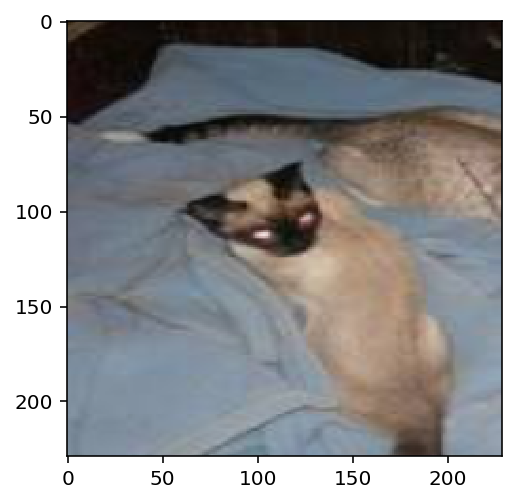

I am 99.96% sure this is a Cat


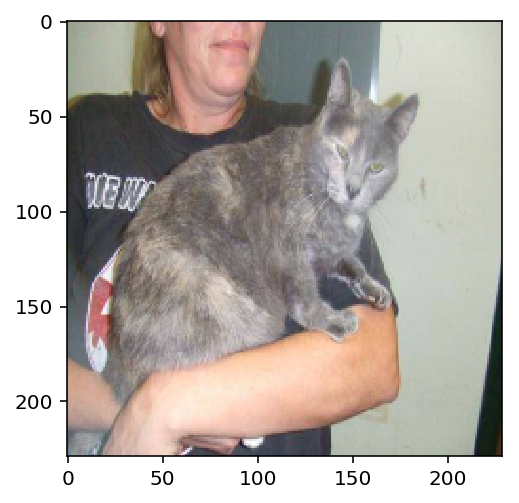

I am 100.00% sure this is a Dog


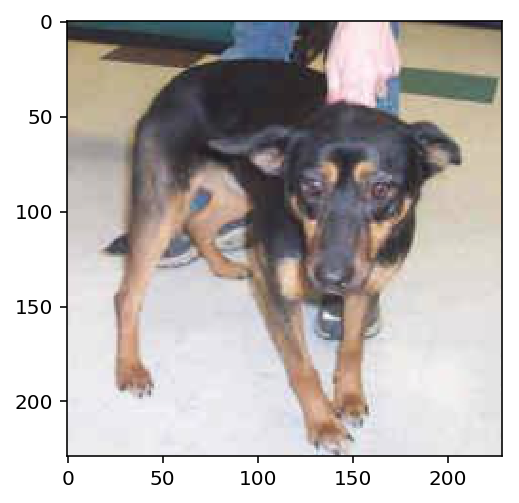

I am 100.00% sure this is a Cat


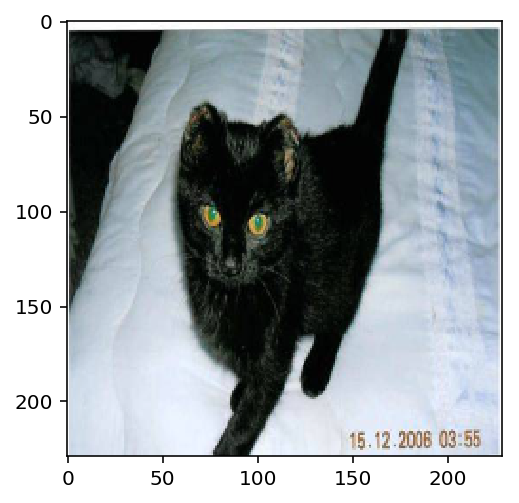

I am 100.00% sure this is a Cat


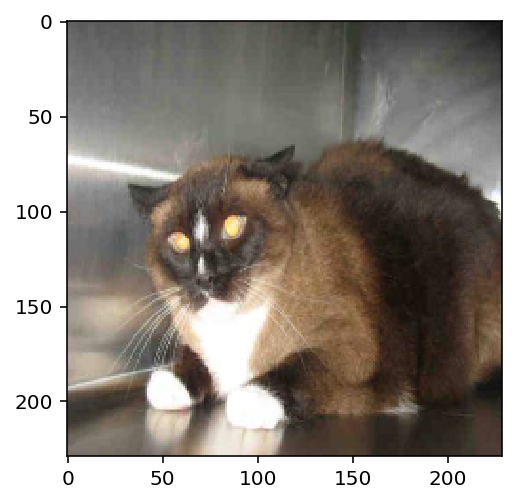

I am 99.93% sure this is a Dog


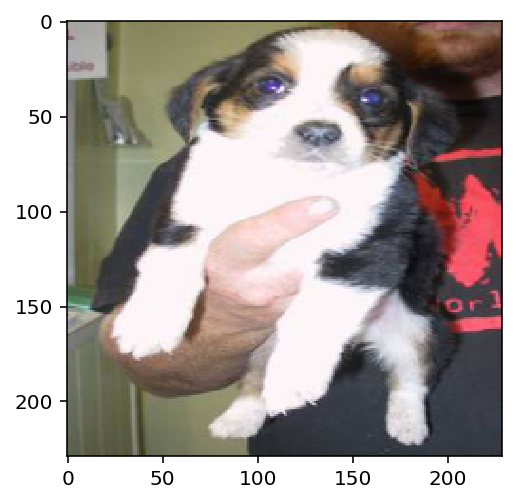

I am 100.00% sure this is a Dog


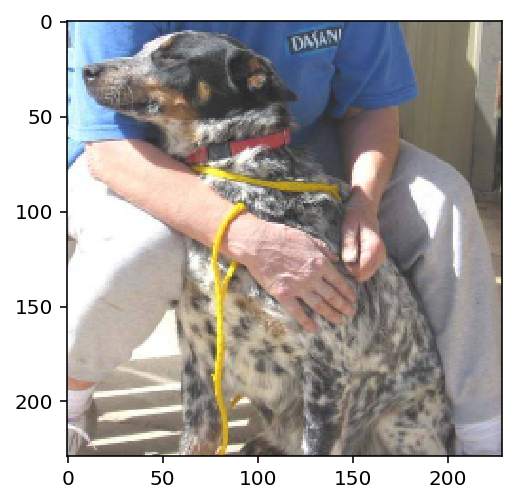

I am 93.66% sure this is a Dog


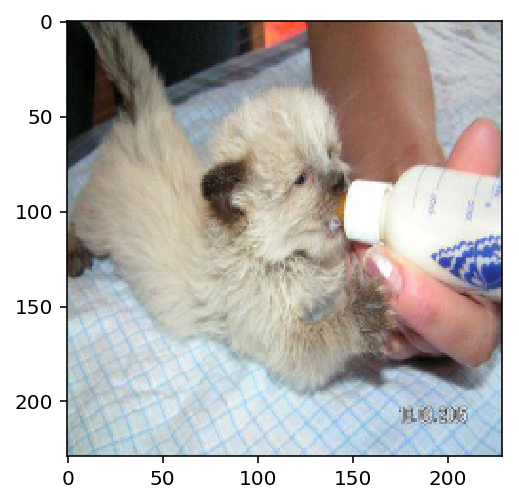

I am 100.00% sure this is a Cat


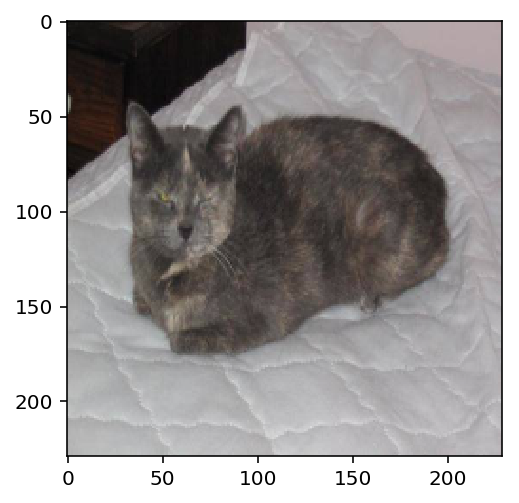

I am 100.00% sure this is a Dog


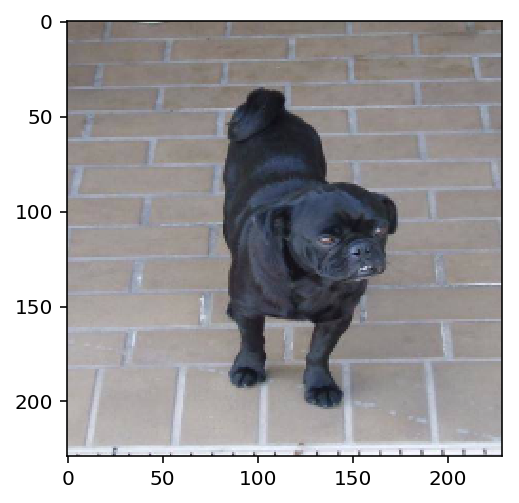

I am 100.00% sure this is a Cat


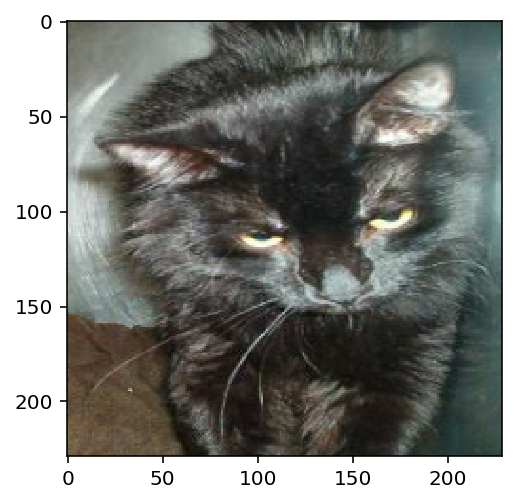

I am 100.00% sure this is a Cat


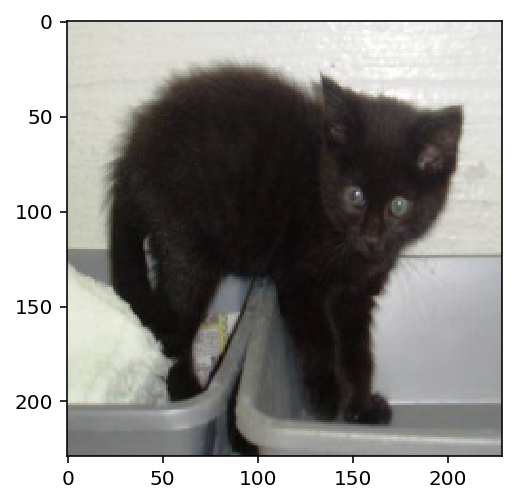

In [10]:
X_test, y_pred = predictOnTestSet(model)
plotPredictions(X_test, y_pred)

### 测试朋友圈的图片

100%|██████████| 8/8 [00:00<00:00, 59.00it/s]


I am 98.73% sure this is a Dog


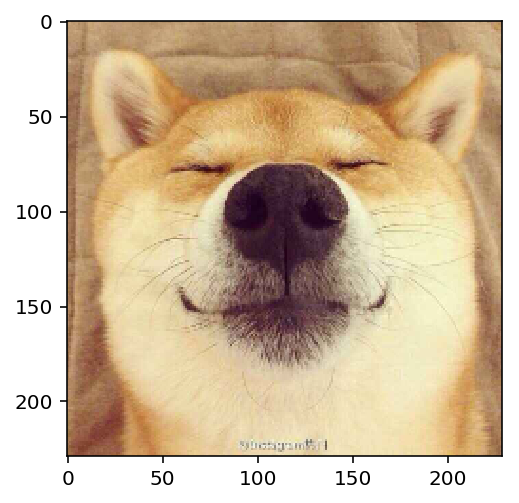

I am 100.00% sure this is a Dog


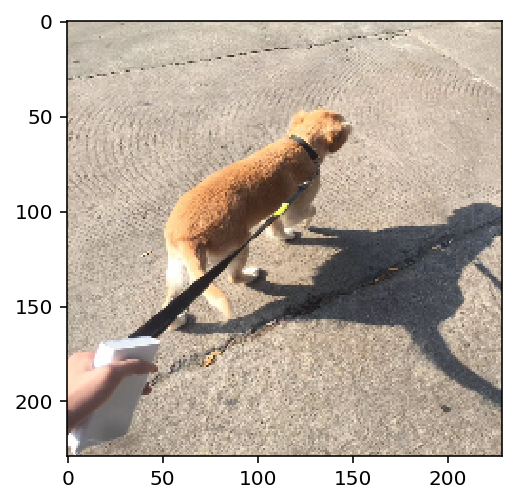

I am 98.04% sure this is a Cat


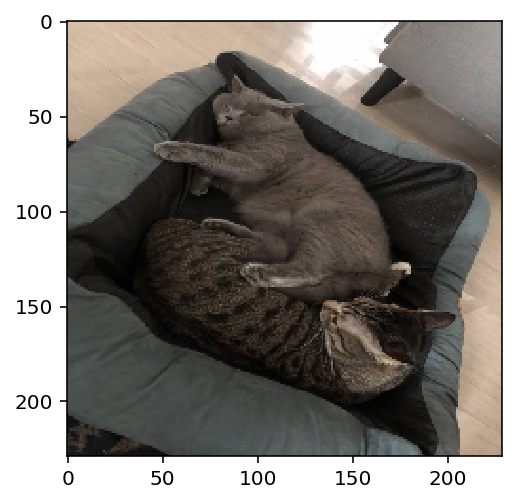

I am 100.00% sure this is a Dog


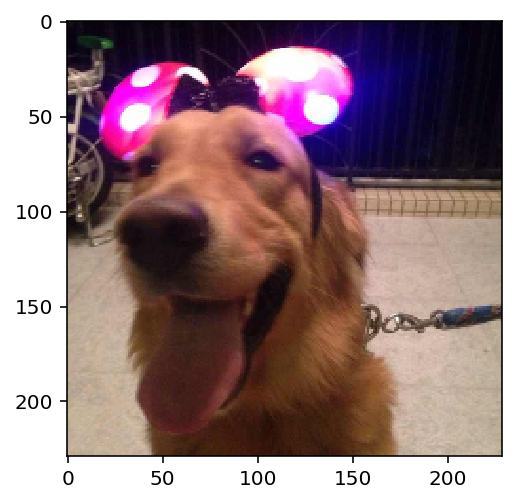

I am 100.00% sure this is a Cat


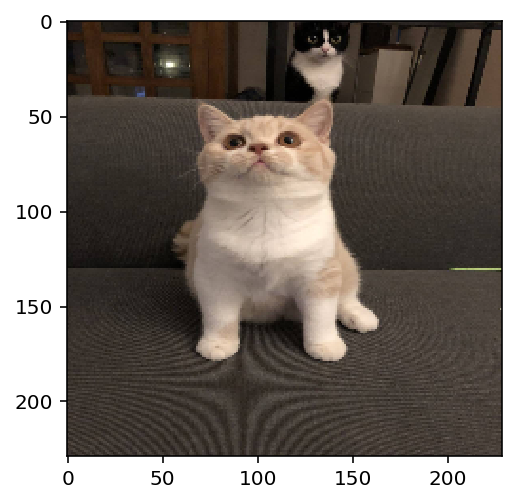

I am 99.99% sure this is a Cat


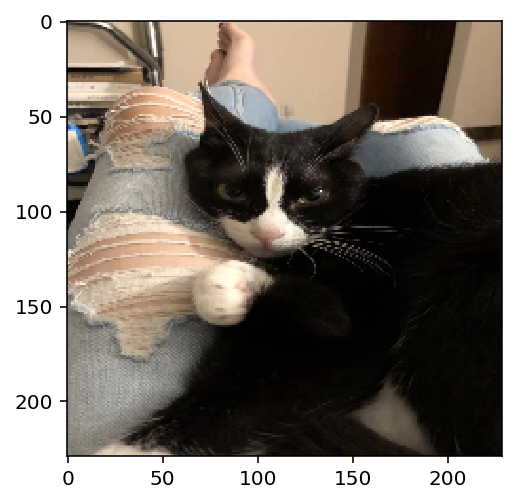

I am 99.98% sure this is a Cat


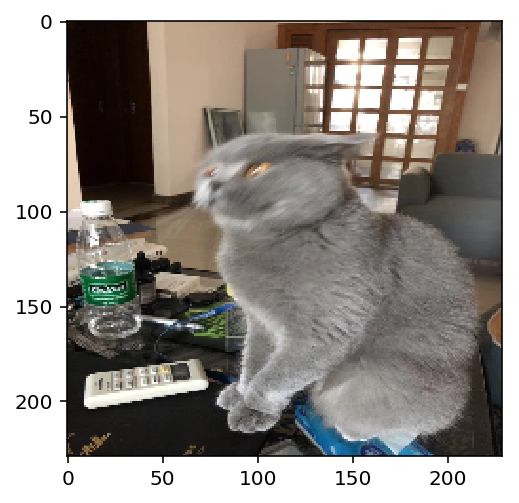

I am 99.97% sure this is a Dog


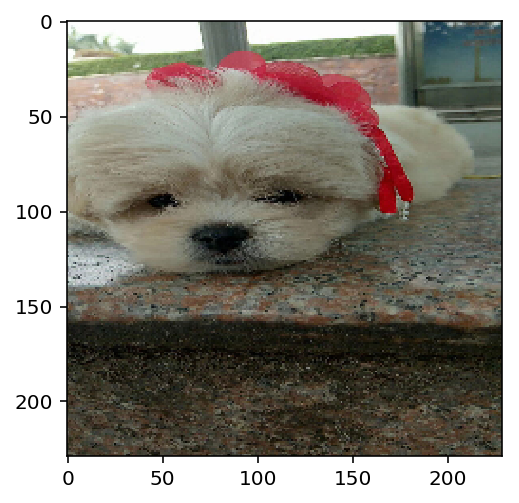

In [11]:
images_path_actual = os.listdir('../../course/input/photo/')
actual_n = len(images_path_actual)
X_actual = np.zeros((actual_n, width, width, 3), dtype=np.uint8)
y_actual = np.zeros((n, n_class), dtype=np.uint8)
for i in range(actual_n):
    images_path_actual[i] = '../../course/input/photo/' + images_path_actual[i]
for i in tqdm(range(actual_n)):
    data = cv2.imread(images_path_actual[i])
    X_actual[i] = cv2.resize(data, (width, width))
y_pred_actual = model.predict(X_actual, batch_size=32)
for i in range(actual_n):
    if y_pred_actual[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(y_pred_actual[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-y_pred_actual[i][0]))

    plt.imshow(X_actual[i][:,:,::-1])
    plt.show()

In [12]:
df = pd.read_csv(prefix + 'sample_submission.csv')
df['label'] = y_pred
df.to_csv('pred.csv', index=None)